<a href="https://colab.research.google.com/github/Balajinanda/Large-Language-Models/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing libraries**

In [76]:
pip install datasets

In [77]:
# Required libraries
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from transformers import BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader

# **Loading the dataset**

In [78]:
# Load the TREC-6 dataset
dataset = load_dataset('trec')

# Inspect the dataset structure
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'coarse_label', 'fine_label'],
        num_rows: 5452
    })
    test: Dataset({
        features: ['text', 'coarse_label', 'fine_label'],
        num_rows: 500
    })
})


# **Data Overview**

In [79]:
print(dataset['train'].features)

{'text': Value(dtype='string', id=None), 'coarse_label': ClassLabel(names=['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'], id=None), 'fine_label': ClassLabel(names=['ABBR:abb', 'ABBR:exp', 'ENTY:animal', 'ENTY:body', 'ENTY:color', 'ENTY:cremat', 'ENTY:currency', 'ENTY:dismed', 'ENTY:event', 'ENTY:food', 'ENTY:instru', 'ENTY:lang', 'ENTY:letter', 'ENTY:other', 'ENTY:plant', 'ENTY:product', 'ENTY:religion', 'ENTY:sport', 'ENTY:substance', 'ENTY:symbol', 'ENTY:techmeth', 'ENTY:termeq', 'ENTY:veh', 'ENTY:word', 'DESC:def', 'DESC:desc', 'DESC:manner', 'DESC:reason', 'HUM:gr', 'HUM:ind', 'HUM:title', 'HUM:desc', 'LOC:city', 'LOC:country', 'LOC:mount', 'LOC:other', 'LOC:state', 'NUM:code', 'NUM:count', 'NUM:date', 'NUM:dist', 'NUM:money', 'NUM:ord', 'NUM:other', 'NUM:period', 'NUM:perc', 'NUM:speed', 'NUM:temp', 'NUM:volsize', 'NUM:weight'], id=None)}


In [80]:
print(dataset['test'].features)

{'text': Value(dtype='string', id=None), 'coarse_label': ClassLabel(names=['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'], id=None), 'fine_label': ClassLabel(names=['ABBR:abb', 'ABBR:exp', 'ENTY:animal', 'ENTY:body', 'ENTY:color', 'ENTY:cremat', 'ENTY:currency', 'ENTY:dismed', 'ENTY:event', 'ENTY:food', 'ENTY:instru', 'ENTY:lang', 'ENTY:letter', 'ENTY:other', 'ENTY:plant', 'ENTY:product', 'ENTY:religion', 'ENTY:sport', 'ENTY:substance', 'ENTY:symbol', 'ENTY:techmeth', 'ENTY:termeq', 'ENTY:veh', 'ENTY:word', 'DESC:def', 'DESC:desc', 'DESC:manner', 'DESC:reason', 'HUM:gr', 'HUM:ind', 'HUM:title', 'HUM:desc', 'LOC:city', 'LOC:country', 'LOC:mount', 'LOC:other', 'LOC:state', 'NUM:code', 'NUM:count', 'NUM:date', 'NUM:dist', 'NUM:money', 'NUM:ord', 'NUM:other', 'NUM:period', 'NUM:perc', 'NUM:speed', 'NUM:temp', 'NUM:volsize', 'NUM:weight'], id=None)}


In [81]:
# Convert dataset to pandas DataFrame
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

# Check the first few rows of the DataFrame to understand the structure
print(train_df.head())
print(test_df.head())

                                                text  coarse_label  fine_label
0  How did serfdom develop in and then leave Russ...             2          26
1   What films featured the character Popeye Doyle ?             1           5
2  How can I find a list of celebrities ' real na...             2          26
3  What fowl grabs the spotlight after the Chines...             1           2
4                    What is the full form of .com ?             0           1
                                       text  coarse_label  fine_label
0      How far is it from Denver to Aspen ?             5          40
1  What county is Modesto , California in ?             4          32
2                         Who was Galileo ?             3          31
3                         What is an atom ?             2          24
4          When did Hawaii become a state ?             5          39


# **EDA Analysis**

In [82]:
# Calculate the frequency of each coarse label for training and test sets
train_label_frequencies = train_df['coarse_label'].value_counts()
test_label_frequencies = test_df['coarse_label'].value_counts()

# Get label names from the dataset
label_names = dataset['train'].features['coarse_label'].int2str

In [83]:
# Create a DataFrame for plotting
train_label_data = pd.DataFrame({
    'Label': train_label_frequencies.index.map(label_names),
    'Count': train_label_frequencies.values
})

# Plot the distribution of coarse labels in the training dataset
train_fig = px.bar(
    train_label_data,
    x='Label',
    y='Count',
    title='Coarse Label Distribution in Training Set',
    labels={'Count': 'Frequency', 'Label': 'Coarse Label'}
)
train_fig.update_layout(xaxis={'categoryorder': 'total descending'})

# Show the figure
train_fig.show()

In [84]:
# Create a DataFrame for plotting
test_label_data = pd.DataFrame({
    'Label': test_label_frequencies.index.map(label_names),
    'Count': test_label_frequencies.values
})

# Plot the distribution of coarse labels in the test dataset
test_fig = px.bar(
    test_label_data,
    x='Label',
    y='Count',
    title='Coarse Label Distribution in Test Set',
    labels={'Count': 'Frequency', 'Label': 'Coarse Label'}
)
test_fig.update_layout(xaxis={'categoryorder': 'total descending'})

# Show the figure
test_fig.show()

# **Tokenization of dataset**

In [85]:
# Load the tokenizer
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [86]:
# Define a tokenization function
def tokenize_function(example):
    return tokenizer(
        example['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

# Apply the tokenization function to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Remove the original text column
tokenized_datasets = tokenized_datasets.remove_columns(["text"])

# Rename the labels column
tokenized_datasets = tokenized_datasets.rename_column("coarse_label", "labels")

# Set the format to PyTorch tensors
tokenized_datasets.set_format("torch")

In [87]:
# Inspect the first tokenized example in the training set
print(tokenized_datasets['train'][0])

{'labels': tensor(2), 'fine_label': tensor(26), 'input_ids': tensor([  101,  2129,  2106, 14262,  2546,  9527,  4503,  1999,  1998,  2059,
         2681,  3607,  1029,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
   

In [88]:
# Inspect the first tokenized example in the test set
print(tokenized_datasets['test'][0])

{'labels': tensor(5), 'fine_label': tensor(40), 'input_ids': tensor([  101,  2129,  2521,  2003,  2009,  2013,  7573,  2000, 18567,  1029,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
   

In [89]:
# Assuming 'tokenized_datasets' is already created as shown previously
train_dataset = tokenized_datasets['train']
test_dataset = tokenized_datasets['test']

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# **Loading BERT Model**

In [90]:
# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

# Move the model to the GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Initialize the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



# **Training the model**

In [91]:
# Initialize lists to store metrics
train_losses = []
train_accuracies = []

# Number of epochs
epochs = 3

# Training loop
model.train()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm(train_loader):
        # Move batch to the device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Clear any previously calculated gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Loss computation
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Calculate accuracy
        preds = torch.argmax(outputs.logits, dim=-1)
        correct_predictions += torch.sum(preds == labels).item()
        total_predictions += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1/3


100%|██████████| 171/171 [25:47<00:00,  9.05s/it]


Loss: 0.5779, Accuracy: 0.8111
Epoch 2/3


100%|██████████| 171/171 [25:46<00:00,  9.04s/it]


Loss: 0.1206, Accuracy: 0.9635
Epoch 3/3


100%|██████████| 171/171 [25:53<00:00,  9.08s/it]

Loss: 0.0668, Accuracy: 0.9815


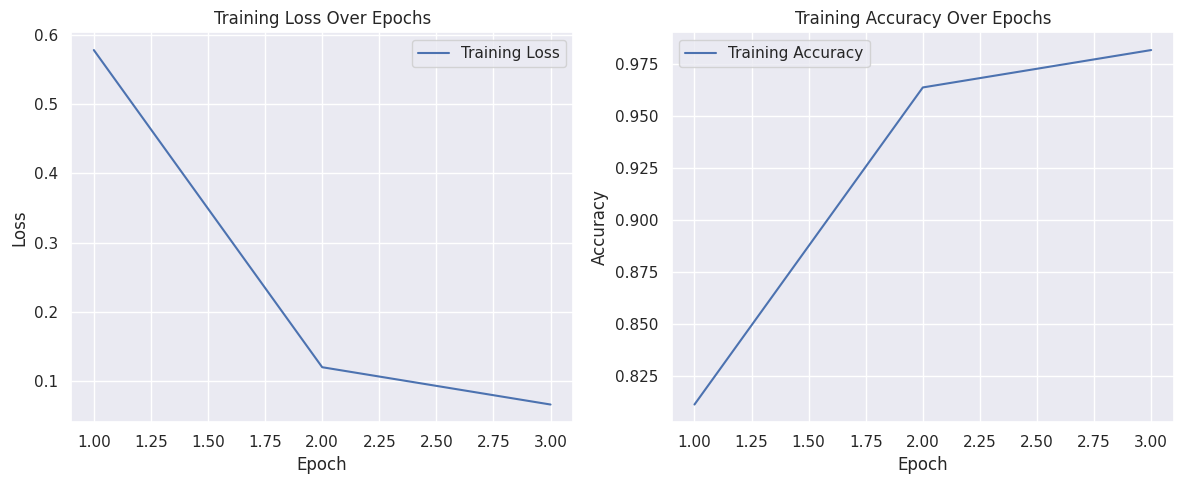

In [92]:
# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# **Model evaluation**

In [93]:
# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9640


# **Results**

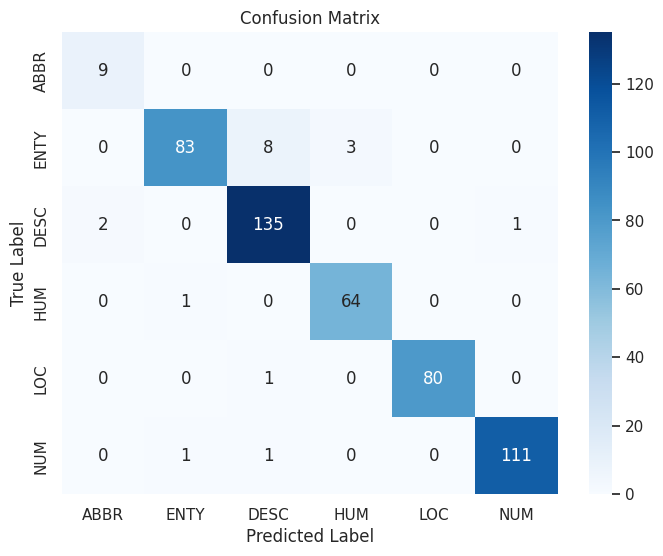

In [94]:
# Ensure label_names is a list of actual label names
label_names = dataset['train'].features['coarse_label'].names

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [95]:
# Classification report
report = classification_report(all_labels, all_preds, target_names=label_names)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

        ABBR       0.82      1.00      0.90         9
        ENTY       0.98      0.88      0.93        94
        DESC       0.93      0.98      0.95       138
         HUM       0.96      0.98      0.97        65
         LOC       1.00      0.99      0.99        81
         NUM       0.99      0.98      0.99       113

    accuracy                           0.96       500
   macro avg       0.95      0.97      0.96       500
weighted avg       0.97      0.96      0.96       500



# **Example predictions**

In [96]:
# Select 5 random indices from the test set
random_indices = random.sample(range(len(tokenized_datasets['test'])), 5)

# Make predictions and print the results
model.eval()
for idx in random_indices:
    # Get the input data
    input_ids = tokenized_datasets['test']['input_ids'][idx].unsqueeze(0).to(device)
    attention_mask = tokenized_datasets['test']['attention_mask'][idx].unsqueeze(0).to(device)

    # Get the true label
    true_label_id = tokenized_datasets['test']['labels'][idx].item()
    true_label = label_names[true_label_id]

    # Make a prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        pred_label_id = torch.argmax(outputs.logits, dim=-1).item()
        pred_label = label_names[pred_label_id]

    # Print the results
    original_text = tokenizer.decode(tokenized_datasets['test']['input_ids'][idx], skip_special_tokens=True)
    print(f"Original Text: {original_text}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {pred_label}\n")

Original Text: what year did wwii begin?
True Label: NUM
Predicted Label: NUM

Original Text: what were christopher columbus'three ships?
True Label: ENTY
Predicted Label: ENTY

Original Text: what is mold?
True Label: DESC
Predicted Label: DESC

Original Text: what is another astronomic term for the northern lights?
True Label: ENTY
Predicted Label: ENTY

Original Text: what is nicotine?
True Label: DESC
Predicted Label: DESC

